## Little Learner

This is the walkthrough of the book [Little Learner](https://www.amazon.com/Little-Learner-Straight-Line-Learning-ebook/dp/B0BCDKRPTJ).

The gist of it:

Deep learning uses neural networks with several (hence "*Deep* learning") layers.

Layers consist of neurons. 

Neuron is some function that takes a tensor (input) and returns a tensor (output). Tensor is n-dimensional array.

All neurons in the same layer take the same tensor. So layer returns a tensor of its neuron outputs. This tensor becomes an input for the next layer etc. The output of the last layer is the output of the NN.

Neural network is a function that takes a tensor and returns a tensor. This function is parametrized by tensor, representing, well, neural network's (actually all of its neuron's) parameters. Neural network can learn good values of parameters. Hence "Deep *learning*".

We have a sample data and we want neural network to learn parameter values that match this data. Learning is done via gradient descent. It's a fancy name for "find partial derivatives of the loss function for each NN parameter and update parameters". Loss function is some measure of how NN output is close to the correct output. We want to minimize loss function's value. 

Let's say NN parameter X has a partial derivative = D at X=p1. This means that D = loss_function(p1 + small_delta) / small_delta (that's the definition of the derivative)

Derivative is a slope of the line that is close to our loss function near the p1. If D is > 0, then we should decrease X (because we want to find a minimum of the loss function). If D is < 0 then we should increase X. So change of X that brings us closer to the minimum is -D * learning_rate. We repeat the same procedure for every parameter. And repeat, repeat, repeat. Total number of repetitions is a hyper-parameter of machine learning. Learning rate is also hyper-parameter. 

We have a bunch of tensor operations in deep learning and GPUs/TPUs can execute these operations really fast.

This were the basics, next steps are learning about specific kinds of neurons, how to represent data with tensors, how to pick hyper-parameters and NN structure etc.


In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

`l2_loss` calculates the loss of target given xs and corresponding ys.
`line` represents, well, a line `mx + b`.

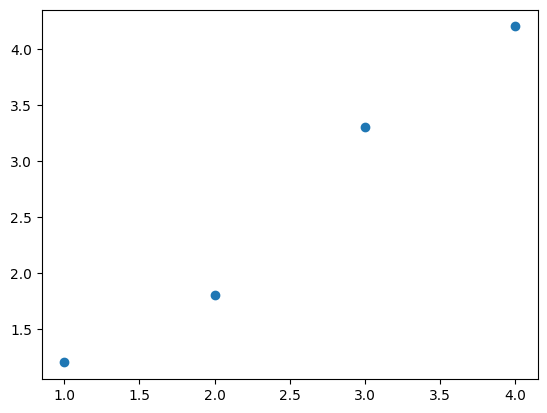

In [3]:
line_xs = np.array([2.0, 1.0, 4.0, 3.0])
line_ys =np.array([1.8, 1.2, 4.2, 3.3])
plt.scatter(line_xs, line_ys);

In [4]:
def l2_loss(target, xs: np.ndarray, ys: np.ndarray):
    def calculate_loss(params: np.ndarray) -> float:
        actual_ys = target(xs, params)
        return np.sum((actual_ys - ys) ** 2)

    return calculate_loss

def line(xs, params: np.ndarray):
    m, b = params
    return m * xs + b


l2_loss(line, xs=line_xs, ys=line_ys)(np.array([0, 0]))

33.21

We have a loss 33.21. That's pretty substantial. Let's improve that.

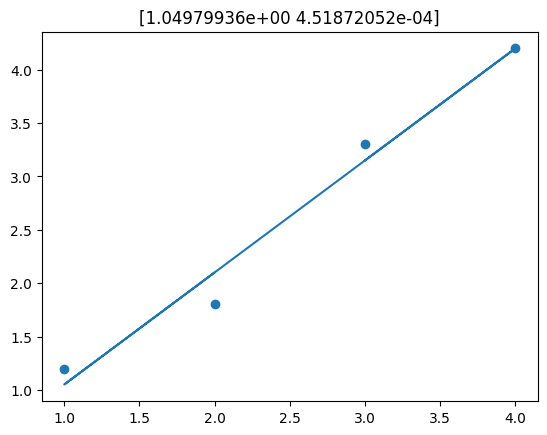

array([1.04979936e+00, 4.51872052e-04])

In [5]:
def learn(target, learning_rates, xs, ys, delta=0.0001, num_iterations=1000):
    # initial params
    params = np.array([0.0, 0.0])
    for i in range(num_iterations):
        loss = l2_loss(target, xs, ys)(params)
        change = np.array([0.0, 0.0])
        # we calculate partial derivatives and update each param
        # using learning_rate
        for j, value in enumerate(params):
            learning_params = params.copy()
            learning_params[j] += delta
            next_loss = l2_loss(target, xs, ys)(learning_params)
            # loss_rate is a gradient
            # we slide the gradient at each point to find the
            # better-fitted params
            loss_rate = (next_loss - loss) / delta
            change[j] -= loss_rate * learning_rates[j]
        params += change
    plt.scatter(line_xs, line_ys)
    plt.plot(line_xs, line(line_xs, params))
    plt.title(f'{params}')
    plt.show()
    return params

learn(line, learning_rates=np.array([0.01, 0.01]), xs=line_xs, ys=line_ys)



Now the line is well-fitted.

In [6]:
def plane(xs, params: np.ndarray):
    # xs is a tensor of tensor_1 (xs=[[0, 0], [1, 1])
    # @ is a dot product
    return params[0] @ xs + params[1]

We can use `plane` in `learn`. Actually let's rename `learn` to `gradient_descent`, because that's what it is.

In [7]:
gradient_descent = learn

Let's extract calculation of partial derivatives to the separate function `gradient` and add `sample_size`
We calculate gradient using random `sample_size` data points at each step. This kind of gradient descent is called stochastic gradient descent.

Stochastic is a fancy word for "random process".

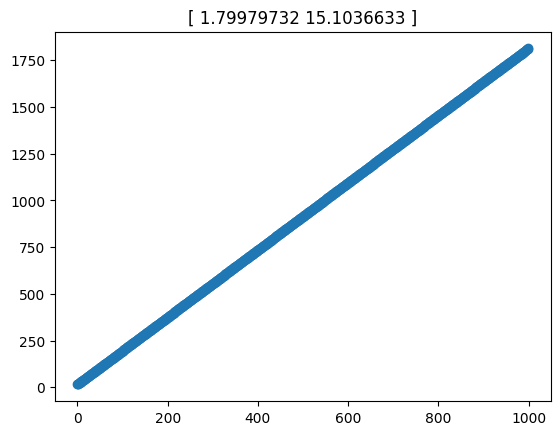

In [8]:
import copy
import itertools


def shape(params):
    if isinstance(params, (list, np.ndarray)):
        return [len(params)] + shape(params[0])
    return []


def get_by_indexes(params, indexes):
    result = params
    for an_index in indexes:
        result = result[an_index]
    return result


def set_by_indexes(params, indexes, value):
    result = params
    for i, an_index in enumerate(indexes):
        is_last = i == len(indexes) - 1
        if is_last:
            result[an_index] = value
        else:
            result = result[an_index]
            
            
def iter_indexes(params):
    if not isinstance(params, (list, np.ndarray)):
        return
    for i, a_param in enumerate(params):
        if isinstance(a_param, (list, np.ndarray)):
            for sub_indexes in iter_indexes(a_param):
                yield (i, *sub_indexes)
        else:
            yield (i,)


def l2_loss_gradient(target, xs, ys, params, delta=0.0001, sample_size=None, verbose=False):
    gs = []
    if sample_size is None:
        indexes = np.arange(0, len(xs))
    else:
        indexes = np.random.randint(0, len(xs), sample_size)
    gradient = copy.deepcopy(params)
    calc_loss = l2_loss(target, xs[indexes], ys[indexes])
    loss = calc_loss(params)
    if verbose:
        print(f'{params=}, {loss=}')
    for indexes in iter_indexes(params):
        set_by_indexes(params, indexes, get_by_indexes(params, indexes) + delta)
        delta_loss = calc_loss(params)
        set_by_indexes(gradient, indexes, (delta_loss - loss) / delta)
        set_by_indexes(params, indexes, get_by_indexes(params, indexes) - delta)
    return gradient


def gradient_descent(target, xs, ys, learning_rates, sample_size=None, delta=0.0001, num_iterations=1000, verbose=False):
    # initial params
    params = np.array([0.0, 0.0])
    for i in range(num_iterations):
        # we calculate partial derivatives and update each param
        # using learning_rate
        gs = np.array(l2_loss_gradient(target, xs, ys, params, sample_size=sample_size, delta=delta))
        base_velocity = -gs * learning_rates
        params += base_velocity
        if verbose:
            print(f'i={i} gs={gs}, params={params}')
    return params

        
def line_plot(xs, ys, learned_params):
    plt.scatter(xs, ys)
    plt.plot(xs, line(xs, learned_params))
    plt.title(f'{learned_params}')
    plt.show()
    
    
def build_loss_plot(target, xs, ys):
    plot_xs = np.linspace(-20, 20, 1000)
    objective_fn = l2_loss(target, xs, ys)
    plot_ys_list = []
    for m in plot_xs:
        params = [m, 0]
        loss = objective_fn(params)
        plot_ys_list.append(loss)
    plot_ys = np.array(plot_ys_list)
    plt.plot(plot_xs, plot_ys)
    plt.title(f'loss(m)')
    plt.show()
    

learned_params = gradient_descent(line, 
                                  np.arange(0, 1000), 
                                  np.arange(0, 1000) * 1.8 + 15, 
                                  sample_size=15,
                                  learning_rates=np.array([1e-8, 1e-2]),
                                  num_iterations=30000,
                                  verbose=False)
line_plot(np.arange(0, 1000), np.arange(0, 1000) * 1.8 + 15, learned_params)


l2_loss is a quadratic function

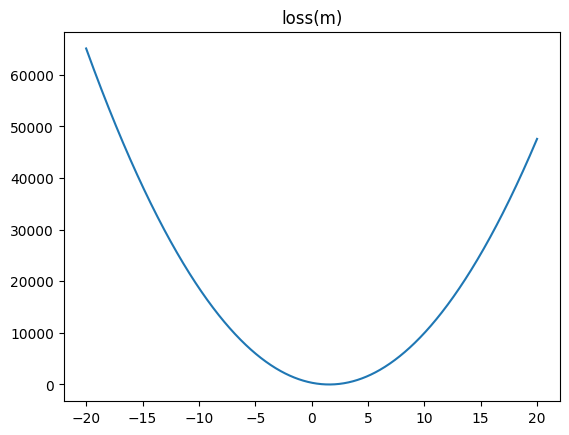

In [9]:
build_loss_plot(line, np.arange(0, 8), np.arange(0, 8) * 1.5 + 0.32)

Let's add some momentum for a gradient descent.
Velocity is a change part of params (-gs * learning_rates)
We take a previous velocity in params and add some part of it to current velocity.

We also generalize gradient_descent, so params can be represented as a list of differently shaped ndarrays.

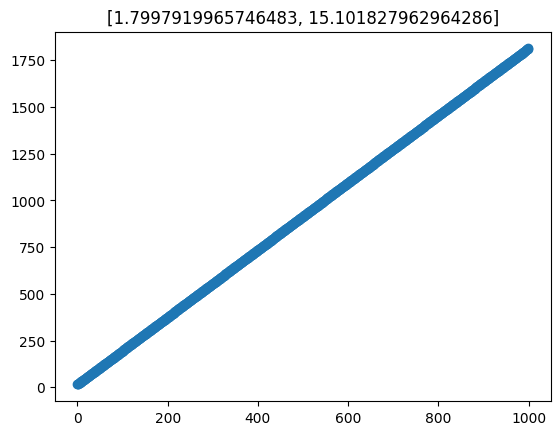

In [10]:
import operator


def params_map_with_index(fn, params):
    result = copy.deepcopy(params)
    for indexes in iter_indexes(params):
        set_by_indexes(result, indexes, fn(indexes, get_by_indexes(params, indexes)))
    return result
        
        
def always(value):
    fn = lambda *args, **kwargs: value
    return fn


def gradient_descent(target, xs, ys, learning_rates=None, initial_params=None, velocity_coeff=0, sample_size=None, delta=0.0001, num_iterations=1000, verbose=False):
    # initial params
    if initial_params is None:
        params = [0, 0]
        prev_velocity = [0, 0]
    else:
        params = initial_params
        prev_velocity = params_map_with_index(always(0.0), params)
        
    if learning_rates is None:
        learning_rates = params_map_with_index(always(1e-2), params)
    for i in range(num_iterations):
        # we calculate partial derivatives and update each param
        # using learning_rate
        gs = l2_loss_gradient(target, xs, ys, params, sample_size=sample_size, delta=delta, verbose=verbose)
        base_velocity = params_map_with_index(lambda indexes, g: -g * get_by_indexes(learning_rates, indexes), gs)
        prev_velocity_part = params_map_with_index(lambda _, v: v * velocity_coeff, base_velocity)
        velocity = params_map_with_index(lambda indexes, prev_value: get_by_indexes(base_velocity, indexes) + prev_value, prev_velocity_part)
        params = params_map_with_index(lambda indexes, v: v + get_by_indexes(params, indexes), velocity)
        if verbose:
            print(f'{i=} {gs=}, {params=}, {velocity=}, {base_velocity=}')
        prev_velocity = velocity
    return params


learned_params = gradient_descent(line, 
                                  np.arange(0, 1000), 
                                  np.arange(0, 1000) * 1.8 + 15, 
                                  sample_size=15,
                                  learning_rates=np.array([1e-8, 1e-2]),
                                  num_iterations=3000,
                                  velocity_coeff=0.9,
                                  verbose=False)
line_plot(np.arange(0, 1000), np.arange(0, 1000) * 1.8 + 15, learned_params)

`smooth`, well, smoothes values.

In [11]:
def smooth(decay_rate, average, g):
    # TODO implement gradient descent with smooth
    return decay_rate * average + (1 - decay_rate) * g

If `decay_rate` == 0.9, then new values only contribute 0.1 of their value to the historical average

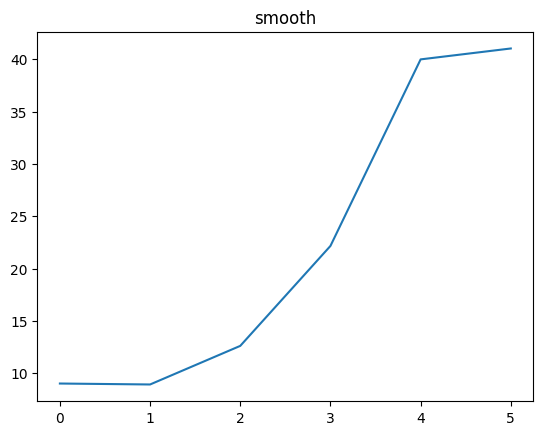

In [12]:
def plot_smooth(decay_rate, values):
    averages = [0.0]
    for a_value in values:
        averages.append(smooth(decay_rate, averages[-1], a_value))
    plt.plot(np.arange(len(values)), np.array(averages[1:]))
    plt.title('smooth')
    plt.show()

plot_smooth(0.9, [90.1, 8.1, 45.8, 108.1, 200.4, 50.4])

Difference between original values is almost 200, and difference between smooth averages is about 30.

Each value contributes lesser and lesser value to the average with the passing of time

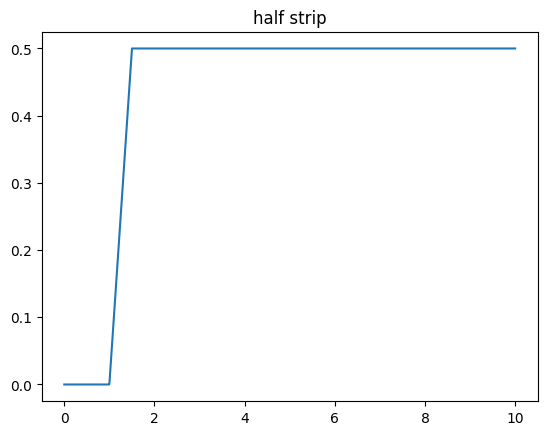

In [13]:


def rectify(s):
    # we are using np.maximum, so `rectify` also works on arrays
    return np.maximum(s, 0)

def linear(t, params):
    if len(t.shape) == 2: # several input tensors
        return (t @ params[0].T) + params[1]
    elif len(t.shape) == 1: # one input tensor
        return params[0] @ t  + params[1]
    else:
        raise ValueError(f'unexpected shape length: {t.shape=}')

def relu(t, params):
    # REctifying Linear Unit
    # params[0] is an array of weights
    # params[1] is a bias
    return rectify(linear(t, params))

def A(*values):
    return np.array(values)

def F(value):
    return np.float64(value)

def half_strip(x, params):
    return relu(x, [params[0], params[1]]) - relu(x, [params[0], params[2]])


def plot_fn(fn, xs, title=None):
    plt.plot(xs, fn(xs))
    plt.title(title or getattr(fn, '__name__', None) or str(fn))
    
    
import functools
    
    
plot_fn(functools.partial(half_strip, params=[A(1.0), F(-1.0), F(-1.5)]),
        xs=np.linspace(0, 10, 1000).reshape(1000, 1),
        title='half strip')

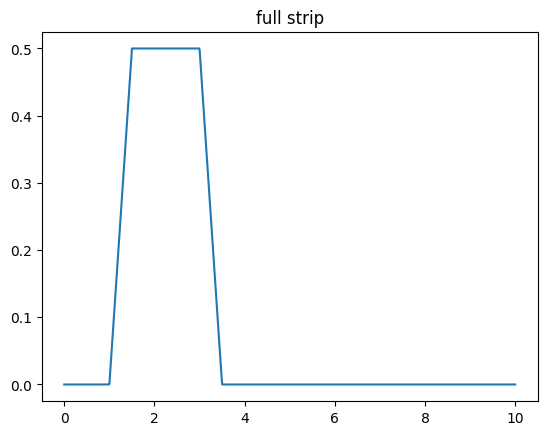

In [14]:
def full_strip(x, params):
    return half_strip(x, params[:3]) - half_strip(x, params[3:])

plot_fn(functools.partial(full_strip, params=[A(1.0), -1.0, -1.5, A(1.0), -3.0, -3.5]),
        xs=np.linspace(0, 10, 1000).reshape(1000, 1),
        title='full strip')

We can approximate any function using `half_strip` and `full_strip`

We can build neural networks with the layers of neurons. `relu` is an example of neuron.

Layer consists of `m` neurons, takes a tensor of shape `(n)`, and returns a tensor of shape `(m)`

`relu` can act as a layer. We can rephrase the comment in `relu` about the nature of `params`

In [15]:
def relu(t, params):
    # params[0] is a tensor(m, n), where m is number of neurons and n is a size of input
    # params[1] is a tensor(m)
    # code of relu/rectify/linear doesn't need changes, because numpy is awesome and reshapes arrays to a common shape
    return rectify(linear(t, params))

Let's implement a neural network.

In [16]:
Tensor1 = np.ndarray
Layer = list[(np.ndarray, Tensor1)]
    

def relu_neural_network(input_: Tensor1, layers: list[Layer]) -> Tensor1:
    """Put an `input_` through neural network consisting of `layers`"""
    output = input_
    for a_layer in layers:
        output = relu(output, a_layer)
    return output


def make_layers(shapes: list[((int, int, ...), (int,))]) -> list[Layer]:
    layers = []
    for weights_shape, bias_shape in shapes:
        # 0 for mean and 2 / weights_shape[-1] is a good choice to avoid instability and vanishing problems 
        # instability: when output of nn becomes too large
        # vanishing: when output of nn becomes too small
        if len(weights_shape) == 2:  # relu
            weights = np.random.normal(0, 2 / weights_shape[-1], weights_shape)
        elif len(weights_shape) == 3:  # recu
            weights = np.random.normal(0, 2 / (weights_shape[1] * weights_shape[2]), weights_shape)
        elif len(weights_shape) == 0:  # signal_avg
            weights = np.zeros(0)
        else:
            raise ValueError(f'bad {len(weights_shape)=}, should be in [2, 3]')
        bias = np.zeros(bias_shape)
        layers.append([weights, bias])
    return layers


def run_network(input_, layers=None):
    # network with two layers, first layer has 10 neurons, second layer has 3 neurons
    # network expects input of shape [5]
    if layers is None:
        layers = make_layers([((10, 5), (10,)), ((3, 10), (3,))])
    model = functools.partial(relu_neural_network, layers=layers)
    return model(input_=input_)
    
    
# rand(5), because network expects input of shape [5]
print(run_network(np.random.rand(5)))


[0.33869551 0.         0.        ]


We have a lot of zeroes in the output, because of the `rectify` which zeroes out all negative values.
Let's run gradient descent on some data.

In [17]:
def run_gradient_descent_on_nn():
    layers = make_layers([((10, 5), (10,)), ((5, 10), (5,))])  # layer with 1 neuron
    xs = np.arange(300).reshape(60, 5)        # 200 inputs of length 5
    learned_params = gradient_descent(relu_neural_network, 
                                  xs,
                                  xs * 1.8 + 15,
                                  initial_params=layers,
                                  learning_rates=params_map_with_index(always(1e-8), layers),
                                  sample_size=5,
                                  num_iterations=3000,
                                  verbose=False)
    print(f'{learned_params=}')
    print(run_network(np.arange(200, 230).reshape(6, 5), learned_params))
    
# because we predict linear function with relu the results are not optimal, but pretty close if input is not close to 0
run_gradient_descent_on_nn()


learned_params=[[array([[ 0.57890056,  0.46996973,  0.52596366, -0.16165749,  0.0037106 ],
       [-0.04474585,  0.02220394, -0.1348917 , -0.37504285, -0.06574797],
       [ 0.14610832, -0.67490641,  0.27557626, -0.00134983,  0.29326026],
       [-0.15590957,  0.31260256, -0.44949133,  0.05107434,  0.03066112],
       [ 0.23387136,  0.11070647, -0.26217032,  0.40794965, -0.41723136],
       [-0.24595827,  0.02418455, -0.50782028, -0.35242159,  0.23363839],
       [ 0.41894071, -0.17771663,  0.35313546, -0.13444524,  0.82283473],
       [-0.14256273,  0.16390467, -0.14194804,  0.36806525,  0.5563572 ],
       [ 0.07267584,  0.21917651,  0.20010068, -0.49042291, -0.15273541],
       [ 0.11954105,  0.19529163,  0.00987571, -0.14614418, -0.34965086]]), array([ 1.29945221e-03,  0.00000000e+00, -3.89049074e-04,  0.00000000e+00,
       -3.17743169e-05,  0.00000000e+00,  1.13995901e-03,  1.38602575e-03,
        0.00000000e+00,  0.00000000e+00])], [array([[-0.09435409, -0.19360536,  0.19717817,

Let's implement correlation/convolution.

In [18]:
def correlate(t, params):
    result = []
    for sub_t in t:
        if len(sub_t.shape) == 1:
            sub_t = sub_t.reshape(len(sub_t), 1)

        padding = np.zeros((params[0].shape[1] // 2, params[0].shape[2]))
        
        padded_t = np.concatenate((padding, sub_t, padding.copy()), axis=0)
        sub_result = []
        for filter_, bias in zip(params[0], params[1]):
            window = filter_.shape[0]
            cur = []
            for i in range(len(sub_t)):
                cur.append(bias + np.sum(element_wise_product(padded_t[i:i + window], filter_)))
            sub_result.append(cur)
        result.append(sub_result)
    np_result = np.array([sub.T for sub in np.array(result)])
    return np_result

def recu(t, params):
    # params is list of tensor_3 (with a bank of filter_2) and tensor_1
    # shape of the layer is (n, d) -> (b, m, d) -> (n, b)
    # d signals of length n are converted to b signals of length n
    return rectify(correlate(t, params))


def element_wise_product(first, second):
#     print(f'{first=}, {second=}')
    return np.array([f @ s for f, s in zip(first, second)])


def signal_avg(t, params):
    # t is a signal_2 or a list of signal_2
    del params  # unused
#     print(f'{t.shape=}')
    result = []
    for sub_t in t:
        num_segments = sub_t.shape[0]
        result.append(sub_t.sum(axis=0) / num_segments)
    return np.array(result)


def run_gradient_descent_on_recu_nn():
    # (5) -> relu -> (2) -> (2, 1) -> recu(5, 5, 1) -> (2, 5) -> signal_avg -> (5)
    layers = make_layers([((2, 5), (2,)), ((5, 5, 1), (5,)), ((), (0,))])
    xs = np.arange(300).reshape(60, 5)        # 60 inputs of length 5
    learned_params = gradient_descent(functools.partial(neural_network,  fns=[relu, recu, signal_avg]),
                                  xs,
                                  xs * 1.8 + 15,
                                  initial_params=layers,
                                  learning_rates=params_map_with_index(always(1e-8), layers),
                                  sample_size=5,
                                  num_iterations=300,
                                  verbose=False)
    print(f'{learned_params=}')
    print(neural_network(np.arange(200, 230).reshape(6, 5), learned_params, fns=[relu, recu, signal_avg]))

    
    
    
def neural_network(input_: Tensor1, layers: list[Layer], fns: list) -> Tensor1:
    """Put an `input_` through neural network consisting of `layers`"""
    output = input_
    for fn, a_layer in zip(fns, layers):
        output = fn(output, a_layer)
    return output


run_gradient_descent_on_recu_nn()
    


learned_params=[[array([[ 0.29612775, -0.20950114, -0.37495573,  0.27151845, -0.0538703 ],
       [ 0.48698389,  0.76924974,  0.00599782,  1.35782826,  1.08880244]]), array([0.        , 0.00277347])], [array([[[-0.08992013],
        [-0.50149066],
        [ 0.50836512],
        [ 0.49055589],
        [-0.21446374]],

       [[ 0.4719944 ],
        [ 0.11249267],
        [ 0.46613047],
        [ 0.53736198],
        [-0.20046   ]],

       [[ 0.45528685],
        [ 0.5988522 ],
        [ 0.46425894],
        [ 0.54490589],
        [ 0.03092362]],

       [[ 0.57795519],
        [ 0.29536824],
        [-0.71937155],
        [ 0.9947364 ],
        [ 0.18183854]],

       [[ 0.67988929],
        [ 0.26276054],
        [ 1.02833735],
        [-0.53294396],
        [-0.20357409]]]), array([0.00175478, 0.00183536, 0.00164583, 0.00103552, 0.00055063])], [array([], dtype=float64), array([], dtype=float64)]]
[[375.08917588 376.80579612 378.93554456 373.51664758 386.13331144]
 [384.35132675 386.1

Let's do some real learning with pytorch. pytorch is a tensor and automatic differentiation library. tensor stuff is similar to numpy, but you can run tensor operations on GPU.

net(torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]))=tensor([4.7376, 5.6888, 4.9181, 4.9037, 5.0679], grad_fn=<AddBackward0>)
loss.item()=62.63260269165039


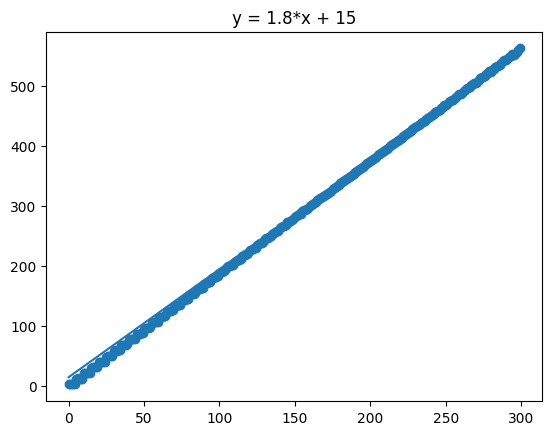

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, 5)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
    
def flatten(tensor):
    return tensor.reshape(tensor.numel())
    
def learn_linear_with_pytorch(num_iterations, learning_rate=0.01, verbose=False, show_plot=False):
    net = Net()
    inputs = torch.arange(300).reshape(60, 5) * 1.0
    outputs = inputs * 1.8 + 15
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    
    for i in range(num_iterations):
        optimizer.zero_grad()
        predictions = net(inputs)
        loss = criterion(predictions, outputs)
        loss.backward()
        optimizer.step()
        if verbose and random.randint(1, 50000) == 1:
            print(f'{i=} {loss.item()=}')
    print(f'{net(torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]))=}')
    print(f'{loss.item()=}')
    if show_plot:
        plt.plot(flatten(inputs), flatten(outputs))
        plot_inputs = torch.arange(300).reshape(60, 5) * 1.0
        plot_outputs = net(plot_inputs).detach()
        plt.scatter(flatten(plot_inputs), flatten(plot_outputs))
        plt.title('y = 1.8*x + 15')
        plt.show()
    

learn_linear_with_pytorch(num_iterations=300, learning_rate=1e-6, verbose=True, show_plot=True)

Even with just 300 iteration the prediction looks similar to the line. Although there's a pretty big difference when x is small. We can fix it by increasing the number of iterations to about 300,000. The loss will close to 0 then.